<a href="https://colab.research.google.com/github/Luluabidah/BDA/blob/main/UASBDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

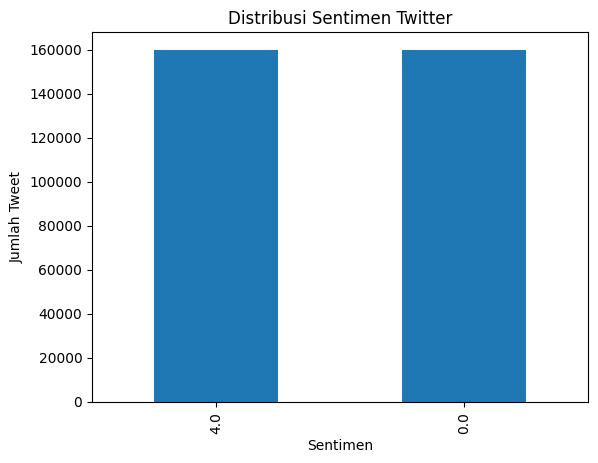

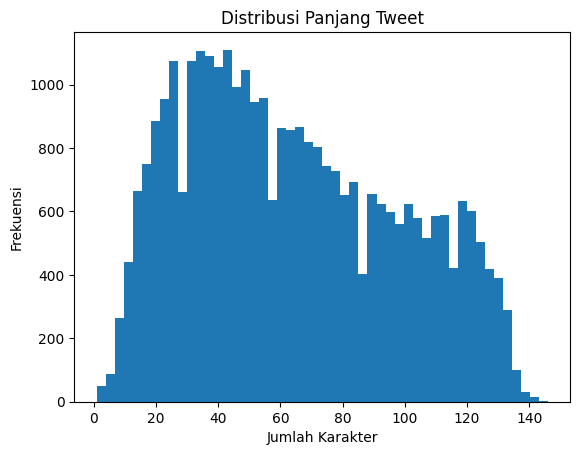

Waktu proses menggunakan Dask   : 10.1960 detik
Waktu proses menggunakan Pandas : 0.0063 detik


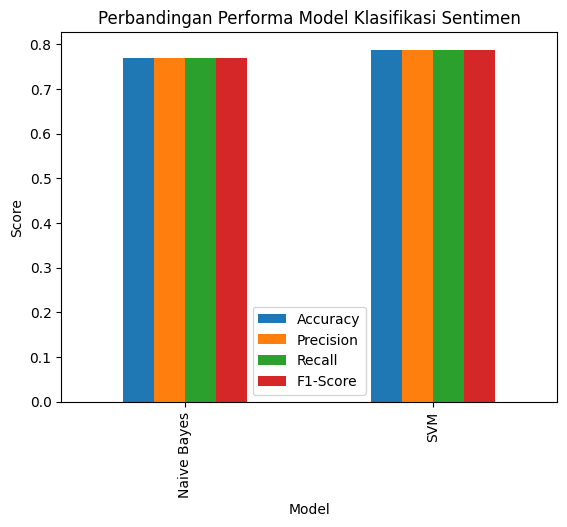

Evaluasi Model Naive Bayes
Accuracy : 0.7691875
Precision: 0.7692887434039801
Recall   : 0.7691875
F1-score : 0.7691695959452827
Evaluasi Model SVM
Accuracy : 0.78759375
Precision: 0.7878734991942038
Recall   : 0.78759375
F1-score : 0.7875365309892195


In [37]:
#from google.colab import files
#files.upload()

!pip install dask[dataframe]

import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = dd.read_csv(
    "training.1600000.processed.noemoticon.csv",
    encoding="latin-1",
    header=None,
    blocksize="32MB",
    assume_missing=True
)

df.head()   # hanya preview, tidak load semua

df.columns = [
    "sentiment",
    "id",
    "date",
    "query",
    "user",
    "text"
]

df.head()

df_sample = df.sample(frac=0.2, random_state=42)

# Menghapus baris data yang memiliki nilai kosong (missing values)
# Tujuannya agar data bersih dan tidak mengganggu proses analisis
df_sample = df_sample.dropna()

# Menghapus data duplikat agar tidak terjadi bias pada analisis
# Setiap tweet hanya dihitung satu kali
df_sample = df_sample.drop_duplicates()

import re  # Library untuk pembersihan teks menggunakan regular expression

# Fungsi untuk membersihkan teks tweet
def clean_text(text):
    text = text.lower()  # Mengubah semua huruf menjadi huruf kecil
    text = re.sub(r"http\S+", "", text)   # Menghapus URL/link
    text = re.sub(r"@\w+", "", text)      # Menghapus mention akun Twitter
    text = re.sub(r"[^a-z\s]", "", text)  # Menghapus angka, simbol, dan tanda baca
    return text  # Mengembalikan teks yang sudah dibersihkan

# Menerapkan fungsi clean_text ke kolom 'text' secara parallel menggunakan Dask
# Hasil disimpan di kolom baru bernama 'clean_text'
df_sample["clean_text"] = df_sample["text"].map(
    clean_text,
    meta=("clean_text", "str")  # Memberi tahu Dask tipe data output
)

# Menampilkan perbandingan teks asli dan teks yang sudah dibersihkan
df_sample[["text", "clean_text"]].head()
# Menghitung jumlah tweet untuk setiap kelas sentimen
# .compute() digunakan untuk mengeksekusi perhitungan Dask
sentiment_counts = df_sample["sentiment"].value_counts().compute()

# Menampilkan hasil perhitungan
sentiment_counts
# Membuat grafik batang untuk melihat distribusi sentimen
sentiment_counts.plot(kind="bar")

# Memberi judul dan label pada grafik
plt.title("Distribusi Sentimen Twitter")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Tweet")

# Menampilkan grafik
plt.show()
# Menghitung panjang teks (jumlah karakter) dari tweet yang sudah dibersihkan
tweet_length = df_sample["clean_text"].map(len, meta=("clean_text", "int"))

# Menghitung statistik deskriptif menggunakan Dask
tweet_length_stats = tweet_length.describe().compute()

# Menampilkan hasil statistik
tweet_length_stats
# Mengambil sebagian data untuk visualisasi agar ringan
tweet_length_sample = tweet_length.sample(frac=0.1, random_state=42).compute()

# Membuat histogram panjang tweet
plt.hist(tweet_length_sample, bins=50)

# Memberi judul dan label grafik
plt.title("Distribusi Panjang Tweet")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Frekuensi")

# Menampilkan grafik
plt.show()

import time  # Untuk mengukur waktu eksekusi
# Mengukur waktu proses perhitungan distribusi sentimen menggunakan Dask
start_time = time.time()

# Operasi agregasi pada data besar (lazy execution)
df_sample["sentiment"].value_counts().compute()

# Menghitung total waktu eksekusi
dask_time = time.time() - start_time

# Menampilkan waktu proses Dask
dask_time

# Mengubah Dask DataFrame menjadi Pandas DataFrame (in-memory)
df_pandas = df_sample.compute()

# Mengukur waktu proses menggunakan Pandas
start_time = time.time()

# Operasi yang sama seperti Dask, tapi tanpa parallel processing
df_pandas["sentiment"].value_counts()

# Menghitung total waktu eksekusi
pandas_time = time.time() - start_time

# Menampilkan waktu proses Pandas
pandas_time

# Menampilkan perbandingan waktu proses
print(f"Waktu proses menggunakan Dask   : {dask_time:.4f} detik")
print(f"Waktu proses menggunakan Pandas : {pandas_time:.4f} detik")

# Mengubah Dask DataFrame menjadi Pandas DataFrame
# Modeling dilakukan di Pandas karena scikit-learn berbasis in-memory
df_pd = df_sample.compute()
# X berisi teks tweet yang sudah dibersihkan
X = df_pd["clean_text"]

# y berisi label sentimen
y = df_pd["sentiment"]
from sklearn.feature_extraction.text import TfidfVectorizer

# Mengubah teks menjadi representasi numerik menggunakan TF-IDF
# max_features dibatasi agar model lebih ringan dan stabil
vectorizer = TfidfVectorizer(max_features=5000)

# Transformasi teks ke bentuk vektor
X_tfidf = vectorizer.fit_transform(X)
from sklearn.model_selection import train_test_split

# Membagi data menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=42
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Membuat model Naive Bayes
nb_model = MultinomialNB()

# Melatih model menggunakan data training
nb_model.fit(X_train, y_train)

# Prediksi data test
y_pred_nb = nb_model.predict(X_test)

# Menghitung akurasi
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_accuracy

from sklearn.svm import LinearSVC

# Membuat model SVM linear
svm_model = LinearSVC()

# Melatih model
svm_model.fit(X_train, y_train)

# Prediksi data test
y_pred_svm = svm_model.predict(X_test)

# Menghitung akurasi
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_accuracy

from sklearn.metrics import precision_score, recall_score, f1_score

# Hitung metrik untuk Naive Bayes
nb_precision = precision_score(y_test, y_pred_nb, average="weighted")
nb_recall = recall_score(y_test, y_pred_nb, average="weighted")
nb_f1 = f1_score(y_test, y_pred_nb, average="weighted")

# Hitung metrik untuk SVM
svm_precision = precision_score(y_test, y_pred_svm, average="weighted")
svm_recall = recall_score(y_test, y_pred_svm, average="weighted")
svm_f1 = f1_score(y_test, y_pred_svm, average="weighted")

import pandas as pd

# Membuat DataFrame berisi perbandingan performa model
metrics_df = pd.DataFrame({
    "Model": ["Naive Bayes", "SVM"],
    "Accuracy": [nb_accuracy, svm_accuracy],
    "Precision": [nb_precision, svm_precision],
    "Recall": [nb_recall, svm_recall],
    "F1-Score": [nb_f1, svm_f1]
})

metrics_df
import matplotlib.pyplot as plt

# Mengatur posisi bar
metrics_df.set_index("Model").plot(kind="bar")

# Memberi judul dan label
plt.title("Perbandingan Performa Model Klasifikasi Sentimen")
plt.ylabel("Score")
plt.xlabel("Model")

# Menampilkan grafik
plt.show()

# Import metrik evaluasi untuk klasifikasi
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# Menghitung metrik evaluasi untuk model Naive Bayes
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision = precision_score(y_test, y_pred_nb, average="weighted")
nb_recall = recall_score(y_test, y_pred_nb, average="weighted")
nb_f1 = f1_score(y_test, y_pred_nb, average="weighted")

# Menampilkan hasil evaluasi
print("Evaluasi Model Naive Bayes")
print("Accuracy :", nb_accuracy)
print("Precision:", nb_precision)
print("Recall   :", nb_recall)
print("F1-score :", nb_f1)

# Menghitung metrik evaluasi untuk model SVM
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm, average="weighted")
svm_recall = recall_score(y_test, y_pred_svm, average="weighted")
svm_f1 = f1_score(y_test, y_pred_svm, average="weighted")

# Menampilkan hasil evaluasi
print("Evaluasi Model SVM")
print("Accuracy :", svm_accuracy)
print("Precision:", svm_precision)
print("Recall   :", svm_recall)
print("F1-score :", svm_f1)



























